# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 16 -- Network Analysis
******
March 28, 2022

<img src="https://s2.glbimg.com/J-25mCP-cFAvRrptFD-RDJY8O2M=/0x0:1008x1043/1008x0/smart/filters:strip_icc()/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2021/H/s/UoNwPLQmOVFCQyTJIFBQ/19chuva.jpg" width=500 align='right' title='Crianças na chuva. Carla Vieira, 2021.'>

# Agenda
1. Announcements
2. Why networks?
3. Pandana
4. OSMnx
5. For next time
6. Questions


# 1. Announcements

- None!

# 2. Network data: not just for transportation planning!

## 2.1. Review: Berkeley BART distances

If you made it to the end of the lecture 14 notebook, you would have seen this image:
<img src="images/berkeley_bart.png">

This was the final step in a geopandas workflow in which we computed distance to the nearest BART station for every Census Block in Berkeley. If you didn't get that far in the notebook, it would be a good idea to spend some time working through it on your own.

## 2.2. Accessibility

- Our investigation of distance-to-BART investigation is a rudimentary example of accessibility analysis
- **Accessibility** is a very important, but broadly defined, topic in land use and transportation planning
- In general, accessibility is a conceptual framework for thinking about:
  - distribution of amenities/opportunities in space
  - relative ease/difficulty of reaching these resources
  - equity/justice-oriented issues relating to the built environment

**Question:** How do you measure accessibility?

- There is no one right way:
  - Attribute of what?
      - geography
      - population
  - Aggregate or singular?
    - one-to-one (e.g. shortest path)
    - many-to-one (e.g. nearest neighbor)
    - one-to-many (e.g. cumulative opportunities)
  - Unit of measure?
    - impedances (e.g. distance, time, cost)
    - density

**Question:** What made the BART distance analysis "rudimentary"?

A more realistic approach would make use of the geometries of the paths that people actually traverse.

## 2.3. Cue...networks!

<img src="https://biohaviour.com/wp-content/uploads/2020/11/SlimeMold.gif" align="right">

- Networks are most commonly used to describe relationships between interconnected entities
    - incredibly useful for measuring accessibility
- Offers abstract representation of both
  1. the distribution of things in relation to some exogenously defined reference
     - e.g. coordinates in a CRS
  2. characteristics of the paths that connect them
     - e.g. impedances, geometries
- In network parlance these entities are called **nodes** and **edges**, respectively. Together, these comprise a data structure known as a **network graph**

- For more, see CYPLAN 290 -- Urban Systems and Network Science (Prof. Marta Gonzalez)

## 2.4. Transportation Networks

### 2.4.1. Characteristics
- Typically modeled with intersections as the nodes and segments between intersections as the edges
- Can be mode-specific -- i.e. walk, bike, drive, transit
- Can be hierarchical -- i.e. freeway vs. local roads

### 2.4.2. Data, where?

- [OpenStreetMap](https://wiki.osmfoundation.org/wiki/Main_Page)
  - Open source, crowdsourced catalog of global transportation network data
    - streets, bike lanes, sidewalks (!)
  - Extras: administrative boundaries, place names, addresses (geocoding), turn-by-turn routing, trip planning, map tiles, building footprints, traffic control
- [Transit.land](https://www.transit.land/) for GTFS data
  - Generalized Transit Feed Specification 
  - Stations, schedules, etc.
    
  

# 3. Pandana: Pandas for Network Analysis

Here we demonstrate the main features of the Pandana library, a Python package for network analysis that uses a fancy algorithm called contraction hierarchies to calculate super-fast travel accessibility metrics and shortest paths.

See full documentation here: http://udst.github.io/pandana/

## 3.1. Loading data

Note: you may need to install OSMnet if Python complains in the next cell:
- `conda install osmnet` or  `pip install osmnet`

In [109]:
from pandana.loaders import osm
import warnings
import pandana
warnings.filterwarnings('ignore')

In [128]:
import geopandas

In [129]:
print(geopandas.__version__)
print(pandana.__version__)

0.9.0
0.6.1


In [106]:
network = osm.pdna_network_from_bbox(37.698, -122.517, 37.819, -122.354)  # San Francisco, CA

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.69800000,-122.51700000,37.81900000,-122.35400000);>;);out;'}"
Downloaded 27,408.9KB from www.overpass-api.de in 7.66 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 10.44 seconds
Returning OSM data with 155,102 nodes and 39,926 ways...
Edge node pairs completed. Took 80.01 seconds
Returning processed graph with 49,550 nodes and 73,737 edges...
Completed OSM data download and Pandana node and edge table creation in 93.53 seconds


## 3.2. Exploring the data

Edges and nodes are visible as DataFrames.

In [107]:
network.nodes_df.head()

,x,y
id,,
33241803,-122.403450,37.805042
33242031,-122.416484,37.799054
54763573,-122.400129,37.774280
54891208,-122.391192,37.770581
54891395,-122.392766,37.769572


In [108]:
network.edges_df.head()

from          to   distance
33241803 2071244784  33241803  2071244784  20.081280
         2071244838  33241803  2071244838  13.973290
         9209919063  33241803  9209919063  12.524052
33242031 65292112    33242031    65292112  71.494105
         65292114    33242031    65292114  75.128715

## 3.3. Reading/Writing to disk

You can't directly save a Pandana network object, but you can easily recreate it from the nodes and edges.

In [ ]:
network.nodes_df.to_csv('nodes.csv')
network.edges_df.to_csv('edges.csv')

In [ ]:
nodes = pd.read_csv('nodes.csv', index_col=0)
edges = pd.read_csv('edges.csv', index_col=[0,1])

In [ ]:
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

## 3.4. Computing shortest paths

Lets download the location of San Francisco restaurants listed on OSM, and then calculate some shortest paths between them.

In [110]:
restaurants = osm.node_query(
    37.698, -122.517, 37.819, -122.354, tags='"amenity"="restaurant"')

Choose two at random and find the closest network nodes to each one:

In [112]:
res = restaurants.sample(2)
res

,lat,lon,amenity,cuisine,name,wheelchair,addr:housenumber,addr:street,addr:city,addr:postcode,...,changing_table:location,brewery,leisure,strapline,noname,short_name,contact:youtube,contact:tripadvisor,was:contact:facebook,website:orders
id,,,,,,,,,,,,,,,,,,,,,
2167584999,37.795790,-122.421924,restaurant,NaN,Lord Stanley,NaN,2065,Polk Street,San Francisco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
808930744,37.786235,-122.408138,restaurant,mexican,Herbert's Mexican Grill,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
res1, res2 = network.get_node_ids(res.lon, res.lat).values

Then use the traverse the network to find the shortest path between them:

In [115]:
network.shortest_path(res1, res2)

array([7231694055, 5027689910, 7231694056, 7231543991,  856296898,
       7231543990, 9292367514,   65334056,   65319616, 7231544008,
         65360281, 7231544006,   65372842,   65362175,   65365837,
       5427170058, 7182831429, 7233579788,   65337410, 7233579785,
       7233579789, 7233543542, 7233543539, 7233543530,   65343971,
       6250503144,   65336974,   65343969,   65307397,  850803362,
       9183941603, 9183941602,  633686735,  633686743,  850803353,
       6250503226,   65295320, 7231525082, 7231525084, 7231525076,
         65326733,   65326736,   65326738,   65319946,   65303546,
        612771497,   65314156,   65312391,   65326740,   65290169,
         65290173,   65313138, 3999644792, 6250503117, 6250503104])

In [116]:
network.shortest_path_length(res1, res2)

2214.907

NOTE: Watch your units!

## 3.5 Calculate many shortest paths at once

Pandana can generate several million shortest paths in ~1 minute.

In [118]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat).values

origs = [o for o in restaurant_nodes for d in restaurant_nodes]
dests = [d for o in restaurant_nodes for d in restaurant_nodes]

In [119]:
%%time
distances = network.shortest_path_lengths(origs, dests)

CPU times: user 3min 42s, sys: 3.02 s, total: 3min 45s
Wall time: 1min 44s


Now we have the distance from each restaurant to each other restaurant.

In [ ]:
import pandas as pd
pd.Series(distances).describe()

## 3.6. Proximity (a.k.a. nearest neighbor)

Here our goal is to find the closest restaurants to each node on the network. Perhaps we are hungrier than we are picky.

To do a network-wide calculation like this, we first need to formally add the restaurants into the network.

In [120]:
network.set_pois(category='restaurants',  # can call it anything we want
                 maxdist=1000,  # don't search for POIs past this distance
                 maxitems=3,
                 x_col=restaurants.lon, 
                 y_col=restaurants.lat)

Now we can run the query

In [121]:
results = network.nearest_pois(distance=1000,
                               category='restaurants',
                               num_pois=3,
                               include_poi_ids = True)
results.head()

,1,2,3,poi1,poi2,poi3
id,,,,,,
33241803,291.376007,348.527008,649.549011,4.077887e+09,1.436066e+09,3.712509e+08
33242031,273.173004,275.235992,290.369995,3.609349e+09,1.478521e+09,1.478521e+09
54763573,282.321014,377.730988,436.976990,1.771741e+09,9.057390e+09,9.477191e+09
54891208,226.173996,304.984009,339.414001,2.453600e+09,2.453600e+09,5.512662e+09
54891395,266.571991,345.381989,391.626007,2.453600e+09,2.453600e+09,6.146447e+09


## 3.7. Network aggregation

Here we ask: "how many restaurants are within 500 meters of each node?" This type of query can be thought of as a measure of **cumulative accessibility**.

In [122]:
restaurant_nodes = network.get_node_ids(restaurants.lon, restaurants.lat)
network.set(restaurant_nodes, name = 'restaurants')

Now we can run the query.

In [126]:
accessibility

id
33241803      2.0
33242031      9.0
54763573      4.0
54891208      7.0
54891395      4.0
             ... 
9613494438    2.0
9613494440    4.0
9613494441    8.0
9613494442    8.0
9613494443    8.0
Length: 49550, dtype: float64

In [123]:
accessibility = network.aggregate(
    distance=500,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='restaurants'
)
accessibility.describe()

count    49550.000000
mean        11.881049
std         18.535044
min          0.000000
25%          0.000000
50%          4.000000
75%         16.000000
max        146.000000
dtype: float64

## 3.8. Visualize your results

Pandana's built-in `plot` function uses an older Matplotlib extension called Basemap that's now difficult to install. So we'll just use Matplotlib directly.

In [124]:
import matplotlib
from matplotlib import pyplot as plt

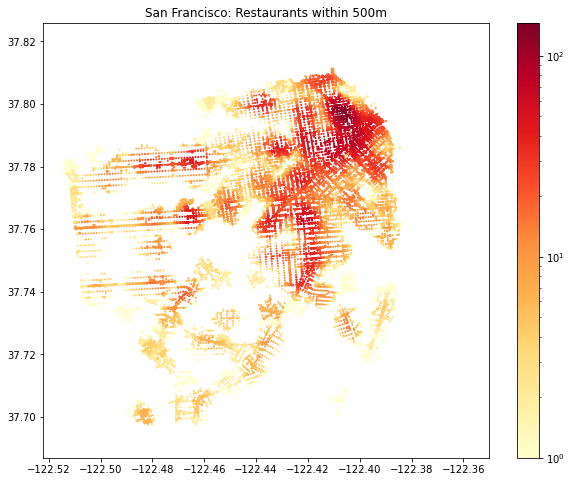

In [125]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('San Francisco: Restaurants within 500m')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar()

plt.show()

# 4. OSMnx: OpenStreetMap + NetworkX

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API.  It makes heavy use of the NetworkX library for network analysis.

https://www.openstreetmap.org  

OSMnx documentation: https://osmnx.readthedocs.io/en/stable/index.html  
OSMnx examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks

NetworkX documentation: https://networkx.github.io/documentation/stable/

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import networkx as nx
import osmnx
print(osmnx.__version__)
osmnx.config(log_file=True, log_console=True, use_cache=True)

## 4.1. Download place boundaries

OSMnx makes it a little easier to download OSM data, especially non-network data like place boundaries or building footprints. See [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/02-example-osm-to-shapefile.ipynb) for more detail.

In [127]:
city = osmnx.geocode_to_gdf('Manhattan, New York, New York, USA')
type(city)

geopandas.geodataframe.GeoDataFrame

In [130]:
city.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"MULTIPOLYGON (((-74.04722 40.69086, -74.04722 ...",40.880449,40.683941,-73.906159,-74.047222,283412835,relation,8398124,40.789624,-73.959894,"Manhattan, New York County, New York, United S...",boundary,administrative,1.185439


### 4.1.1. Reprojection

You can use any standard tools for plotting geodataframe geometries, but OSMNx also has some helper functions for handling projections and basic mapping. You will want to make sure you working with cartesian coordinates before performing any network analysis

In [131]:
# uses the optimal local UTM projection by default
osmnx.project_gdf(city).head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"MULTIPOLYGON (((580503.876 4504877.304, 580504...",40.880449,40.683941,-73.906159,-74.047222,283412835,relation,8398124,40.789624,-73.959894,"Manhattan, New York County, New York, United S...",boundary,administrative,1.185439


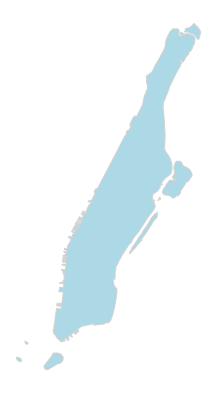

In [132]:
fig, ax = plt.subplots(figsize=(7,7))
osmnx.project_gdf(city).plot(fc='lightblue', ec='lightgrey', ax=ax)
_ = ax.axis('off')

### 4.1.2. Grab multiple places at once

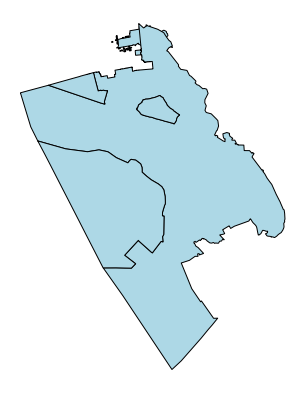

In [133]:
place_names = ['Berkeley, California, USA', 
               'Oakland, California, USA',
               'Piedmont, California, USA',
               'Emeryville, California, USA',
               'Alameda, Alameda County, CA, USA']

east_bay = osmnx.geocode_to_gdf(place_names)

fig, ax = plt.subplots(figsize=(7,7))
osmnx.project_gdf(east_bay).plot(fc='lightblue', ec='k', ax=ax)
_ = ax.axis('off')

### Exercise

Try downloading some other place outlines!

## 4.2. Download and process street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/03-graph-place-queries.ipynb).

Note that a **graph** is the math/computer science term for the data structure you probably think of as a "network": a set of vertices/nodes/points that are connected by edges/links/lines. More [here](https://en.wikipedia.org/wiki/Graph_(abstract_data_type)). This can be confusing because data visualizations are often called "graphs" as well; it seems like this originally referred only to network diagrams but has now expanded to include more things. Consider calling your data visualizations "charts" instead!

You can download a street network by providing OSMnx any of the following:
  - a bounding box
  - a lat-lon point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones


### 4.2.1. Streets within a bounding box
 This constructs the network from all the OSM "nodes" (a.k.a. intersections or vertices) and "ways" (a.k.a. streets, edges, links, etc.) within the bounding box.

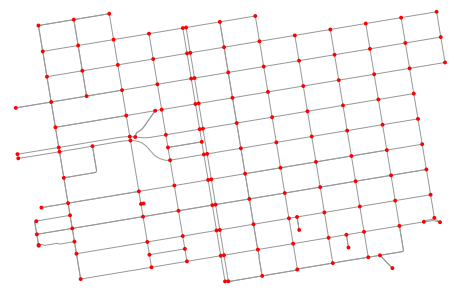

In [134]:
# define a bounding box
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = osmnx.graph_from_bbox(north, south, east, west, network_type='drive')
G1_projected = osmnx.project_graph(G1)

fig, ax = osmnx.plot_graph(G1_projected, bgcolor='none', node_color='red')
fig.show()

In [135]:
type(G1)

networkx.classes.multidigraph.MultiDiGraph

### 4.2.2. Street network by place name

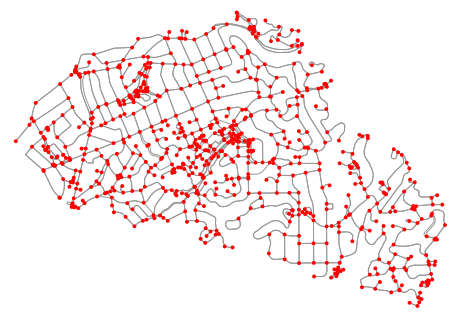

In [136]:
G2 = osmnx.graph_from_place('Piedmont, California, USA')
G2_projected = osmnx.project_graph(G2)
fig, ax = osmnx.plot_graph(G2_projected, bgcolor='none', node_color='red')
fig.show()

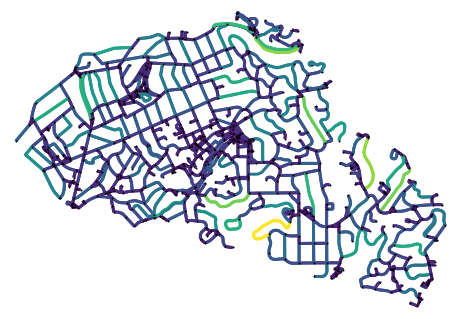

In [137]:
ec = osmnx.plot.get_edge_colors_by_attr(G2_projected, attr='length')
fig, ax = osmnx.plot_graph(
    G2_projected, bgcolor='none',
    node_color='w', node_edgecolor='k', node_size=1, node_zorder=3,
    edge_color=ec, edge_linewidth=3)
fig.show()

### 4.2.3. Street network within a distance radius

- This can be either a straight-line distance (implemented as a bounding box) or a network distance. 
- If it's a *driving* network, the network distances will respect one-way streets, but if it's a *walking* network, two-way travel is allowed everywhere.

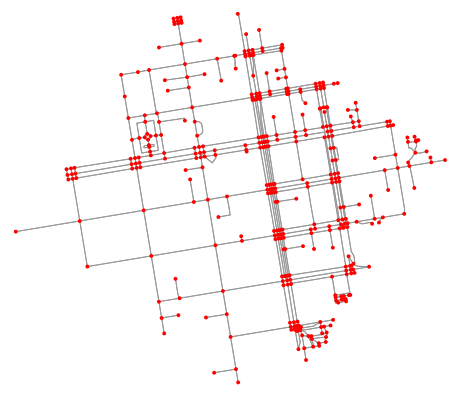

In [138]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network only of nodes within 500m walking along the network from point
G3 = osmnx.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
G3 = osmnx.project_graph(G3)

fig, ax = osmnx.plot_graph(G3, bgcolor='none', node_color='red')
fig.show()

### Exercise

Try getting a specific type of network for some place in the world -- (in the interest of time, don't get too big a city or other geography).  Try for walk vs drive vs some other type.

## 4.3. Converting networks and saving them to disk

Remember that the street networks are *not* GeoDataFrames -- they contain information about both **nodes** (points) and **edges** (lines). When you save them to geospatial formats like a Shapefile or GeoJSON, you'll need two separate files.

For more examples of saving and loading networks to/from disk, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/05-save-load-networks.ipynb).

API documentation for [saving and loading](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.save_load)

### 4.3.1. Network Graph to Shapefile

In [ ]:
osmnx.save_graph_shapefile(G3, filepath='network-shape')

### 4.3.2. To GeoDataFrame, .csv, .geojson

In [139]:
gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(G3)

In [140]:
gdf_nodes.head(3)

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
65287183,4.182879e+06,552315.268000,3,-122.405815,37.791776,NaN,POINT (552315.268 4182878.790)
65287185,4.182871e+06,552268.633184,1,-122.406345,37.791709,NaN,POINT (552268.633 4182871.048)
7231068037,4.182945e+06,552304.222426,4,-122.405935,37.792370,crossing,POINT (552304.222 4182944.571)


In [141]:
gdf_edges.head(3)

osmid          name      highway service  oneway  \
u        v          key                                                        
65287183 65287185   0     8915760  Vinton Court      service   alley   False   
         7231068037 0    29023741  Grant Avenue  residential     NaN   False   
         65328705   0    29023741  Grant Avenue  residential     NaN   False   

                         length  \
u        v          key           
65287183 65287185   0    47.183   
         7231068037 0    66.841   
         65328705   0    30.564   

                                                                  geometry  \
u        v          key                                                      
65287183 65287185   0    LINESTRING (552315.268 4182878.790, 552268.633...   
         7231068037 0    LINESTRING (552315.268 4182878.790, 552304.222...   
         65328705   0    LINESTRING (552315.268 4182878.790, 552320.311...   

                        lanes maxspeed access tunnel  
u        v          key                               
65287183 65287185   0     NaN      NaN    NaN    NaN  
         7231068037 0       1      NaN    NaN    NaN  
         65328705   0       1      NaN    NaN    NaN

In [ ]:
gdf_nodes.to_file('nodes.geojson', driver='GeoJSON')

### Exercise

Take one of the street networks we've loaded, convert its edges to a GeoDataFrame, and generate a list of all the street names.

Hint: the data types are a little messy, but something like this should work for the last step.

`gdf_edges['name'].astype('str').unique()`

## 4.4. Network analysis (topological and metric)

Network analysis is not all about shortest path calculations.  Network science is an entire field of analysis that exlores networks as mathematical / topological 'graphs'.  Also transportation planners use network structure information to inform analysis of travel behavior.  The 3Ds work by Cervero and Kockleman have evolved into 7Ds (or more) by researchers and practitioners trying to understand what urban design characteristics are associated with more walking and less driving.

Below we explore functionality that OSMnx offers, with considerable help from Networkx under the hood, to provide these kinds of calculations. 

For more depth, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb).

In [ ]:
osmnx.basic_stats(osmnx.graph_from_place('Piedmont, California, USA'))

## 4.4.1. Shortest path routing

Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination. The edges can be weighted in various different ways, but distance or travel time are the most common approaches.

In [142]:
location_point = (37.791427, -122.410018)
G = osmnx.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
origin_node = osmnx.get_nearest_node(G, location_point)

164.789


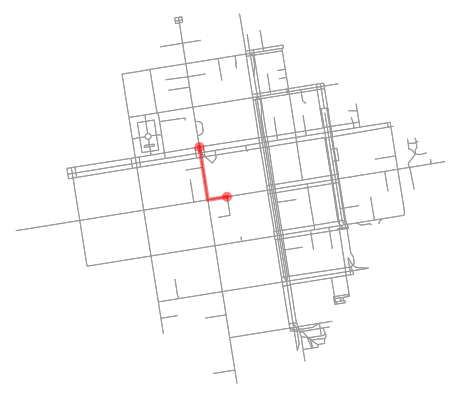

In [153]:
destination_node = pd.Series(list(G.nodes())).sample().values[0]
route = nx.shortest_path(G, origin_node, destination_node)  # this is a NetworkX function
print(nx.shortest_path_length(G, origin_node, destination_node, weight='length'))
fig, ax = osmnx.plot_graph_route(G, route, bgcolor='none', node_color='none')
fig.show()

### Exercise

Pick an area of a city and download the OSM street graph for it. Choose two locations and find the shortest path between them!

Tip: One way to get lat-lon coordinates for arbitrary places is by right-clicking (or control-clicking) on a spot in Google Maps and choosing "What's here".

# 5. For next time

![](https://valhalla.readthedocs.io/en/latest/api/images/isochrone.png)
- Work through the OSMnx [isochrone demo notebook](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb)
- Work through the UrbanAccess [demo notebook](https://github.com/UDST/urbanaccess/blob/dev/demo/simple_example.ipynb)
   - Pandana + GTFS for multi-modal accessibility

# Sources

Sections 3-4 heavily adapted from previous versions of this lecture by Prof. Paul Waddell and Sam Maurer.